# Cholesterol and Blood Pressure Metrics: A Predictive Model for Heart Disease
#### Benjamin Lee, 79964508

## Introduction
### I. Background

The human body's vital organs depend on an adequate supply of oxygen, which is distributed through blood circulation. Conditions which impede proper blood supply from the heart are medically defined as heart disease (Public Health Agency of Canada, 2017). 

According to an article from the Government of Canada's Public Health Agency, factors such as high cholesterol levels and high blood pressure are major contributors to heart disease (Public Health Agency of Canada, 2017), so the objective of this study is to verify whether blood pressure and cholesterol levels are, in fact, strong predictors for heart disease using a classification model. 

### II. Research Question

In this study, I investigate the following inquiry: How accurately can we predict whether an individual has a heart disease based on cholesterol and blood pressure?

### III. Dataset

To pursue this inquiry, I used a modified dataset for heart disease diagnoses from Cleveland, Ohio, collected by the UC Irvine (UCI) Machine Learning Repository. It includes 303 observations from four regions: Cleveland, Hungary, Switzerland, and VA Long Beach. 

## Preliminary Exploratory Data Analysis

In [2]:
# Loading relevant packages from library
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### I. Reading Data into Jupyter Notebook 

In [3]:
# Obtained the heart disease datasets from UCI's heart disease data archives
raw_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)
head(raw_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### II. Tidying Raw Data

In [4]:
set.seed(727)
# Wrangled and tidied the data
tidy_data <- raw_data |>
filter(X12 != "?") |> # Omitting observations which had missing values
mutate(age = as.factor(X1), sex = as.factor(X2), cp = as.factor(X3), trestbps = as.numeric(X4), chol = as.numeric(X5), fbs = as.factor(X6),
       restecg = as.factor(X7), thalach = as.numeric(X8), exang = as.factor(X9), oldpeak = as.numeric(X10),
       slope = as.factor(X11), ca = as.numeric(X12), thal = as.factor(X13), num = X14)  # Defining the variables of interest (based on the key provided by UCI)

# Key (* = used in data):
# age - Age of patient in years
# sex - Sex
# cp - Chest Pain Type
# * trestbps - Resting Blood Pressure (mm Hg)
# * chol - Serum Cholesterol (mg/dL)
# fbs - Fasting Blood Sugar (mg/dL)
# restecg - Resting Electrocardiographic Results
# thalach - Maximum Heart Rate Achieved
# exang - Exercised Induced Angina
# oldpeak - ST depression induced by exercise relative to rest
# slope - The slope of the peak exercise ST segment
# ca - Number of major vessels coloured by Fluoroscopy
# thal - Type of defect
# * num - Presence of heart disease (No = 0, Yes > 0)

heart_data <- tidy_data |>
select(trestbps, chol, num) |>
# ?case_when
mutate(num = case_when(num > 0 ~ "Yes", num == "0" ~ "No")) |>  # Changing num to binary: heart disease or no heart disease
mutate(num = as.factor(num))
head(heart_data)

trestbps,chol,num
<dbl>,<dbl>,<fct>
145,233,No
160,286,Yes
120,229,Yes
130,250,No
130,204,No
120,236,No


In [5]:
set.seed(727)
#splitting data: 75% training, 25% testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### III. Data Analysis

In [10]:
instances <- heart_training |>
    group_by(num) |>
    summarize(instances = n()) #finds the number of yes's and no's
instances

num,instances
<fct>,<int>
No,120
Yes,103


To verify that both classes are about equally represented in the data, I calculated the number of instances where heart disease was present (Yes) and not present (No) and found that they were roughly the same. It is important to ensure that each class is represented equally so that the majority class is not favoured during classification. 

### IV. Data Visualization

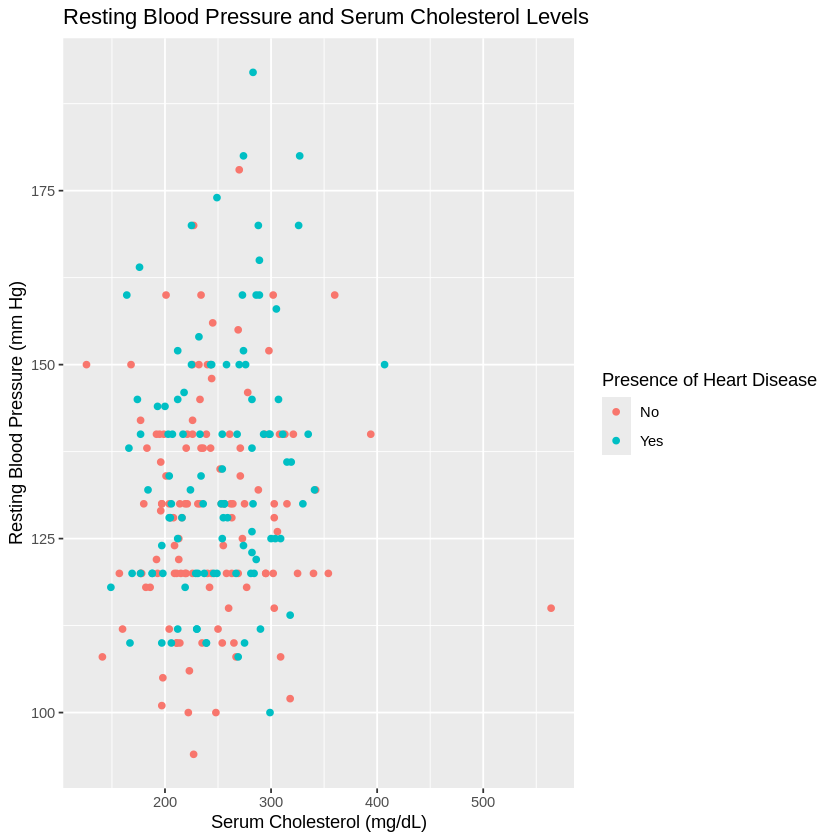

In [9]:
# Prepared a scatterplot of the training data for preliminary analysis
data_plot <- heart_training |>
    ggplot(aes(x = chol, y = trestbps)) +
    geom_point(aes(colour = num)) +
    labs(x = "Serum Cholesterol (mg/dL)", y = "Resting Blood Pressure (mm Hg)", colour = "Presence of Heart Disease") +
    ggtitle("Resting Blood Pressure and Serum Cholesterol Levels")
data_plot

I made a scatterplot of the training data to visualize the relationship between serum cholesterol and blood pressure levels (the predictors), as well as how the heart disease clusters are placed. From looking at this scatterplot, patients who were diagnosed with heart disease tend to have higher serum cholesterol and resting blood pressure levels.

## Methods

#### I. Further Data Analysis
To build the classifier, I will use the k-nearest neighbours (KNN) classification algorithm. This method is more appropriate than regression because the desired outcome (the Presence of Heart Disease) is categorical, rather than quantitative. I will tune the classifier and use five-fold cross-validation to determine whether this classification model is suitable for predicting heart disease.

#### II. Variables
In this study, I will use serum cholesterol levels and resting blood pressure levels as predictors for the presence of heart disease.

#### III. Visualization Method
The primary method for visualizing the data will be through scatterplots. However, I may occasionally use a table to depict the steps that I am taking when building the classifier for this dataset.

## Expected Outcomes and Signifiance

#### I. Hypothesis
I expect to find cholesterol and blood pressure levels to be fairly strong predictors for heart disease.

#### II. Impact

The study's findings will help healthcare professionals allocate resources to developing preventative strategies. By regularly checking cholesterol and blood pressure levels, they could potentially intervene and provide a treatment to prevent the development and progression of heart disease. Furthermore, individuals who are genetically predisposed to heart disease can be better equipped with this knowledge and research necessary changes in lifestyle and diet to reduce the risk of any further health complications.

#### III. Implications and Further Research

While this model is beneficial, it is important to consider that heart disease can be much more complex than high cholesterol and blood pressure levels. Thus, I propose that other variables must be analyzed (i.e. Could obesity also be a predictor for heart disease? How might adding this variable change the accuracy of the classification model?).

## References

Public Health Agency of Canada (2017). Heart diseases and conditions [Education and awareness]. https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions.html
